In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from mpl_toolkits import mplot3d
from matplotlib import cm
from tqdm import tqdm
from collections import defaultdict

In [2]:
class AnalysisParser:

    def __init__(self):
        pass

    def parseAnalysisData(self, filePath):
        with open(filePath) as f:
            lines = f.readlines()

        self.content = ''.join(lines)
        self.chunks = self.getChunks()
        self.analysisData = self.parseChunks()
        return self.analysisData

    def getChunks(self):
        starts = [i.span()[0] for i in re.finditer(r'### ', self.content)]
        ends = [i.span()[0] for i in re.finditer(r'---\n', self.content)]
        chunks = [self.content[s:e] for (s,e) in zip(starts, ends)]
        return chunks

    def extractTitle(self, chunk):
        return re.findall(r'^### (.*)\n', chunk)[0]

    def parseTitle(self, title):
        mu = float(re.findall(r'\$\\mu = (.+?)\$', title)[0])
        sigma = float(re.findall(r'\$\\sigma = (.+?)\$', title)[0])
        denoiser = re.findall(r'Denoiser = `(.+)`', title)[0]
        return mu, sigma, denoiser

    def extractTable(self, chunk):
        table = re.findall(r'(\|(?:.+?)\|(?:.+?)\|\n)', chunk)
        return ''.join(table)

    def parseTable(self, table):
        lines = table.split('\n')
        data = {}

        for line in lines[2:-1]:
            cols = re.findall(r'\|.+\|', line)[0][1:-1].split('|')
            cols = [x.strip() for x in cols]
            metric, val = cols
            if val[-1] == '%':
                val = float(val[:-1])/100
            elif val == 'N/A':
                val = np.nan
            elif val[-1] == 'm':
                val = float(val[:-1])
            else:
                val = float(val)
            
            data[metric] = val
        return data

    def parseChunks(self):
        
        data = defaultdict(lambda: defaultdict(lambda: defaultdict(str)))
        for chunk in self.chunks:
            title = self.extractTitle(chunk)
            mu, sigma, denoiser = self.parseTitle(title)
            table = self.extractTable(chunk)
            tableData = self.parseTable(table)
            data[mu][sigma][denoiser] = tableData
        
        return data

In [3]:
parser = AnalysisParser()
analysisData = parser.parseAnalysisData('../SBAgent/evalResults/model1/bivariate.md')

In [6]:
mus = np.arange(0, 0.21, 0.02)
sigmas = np.arange(0, 2.2, 0.2)

XX = []
YY = []
Z = []

for x in mus:
    XX.append([])
    YY.append([])
    Z.append([])
    for y in sigmas:
        XX[-1].append(x)
        YY[-1].append(y)
        Z[-1].append(analysisData[x][y]['None']['Success Rate'])

X = np.array(XX)
Y = np.array(YY)
Z = np.array(Z)

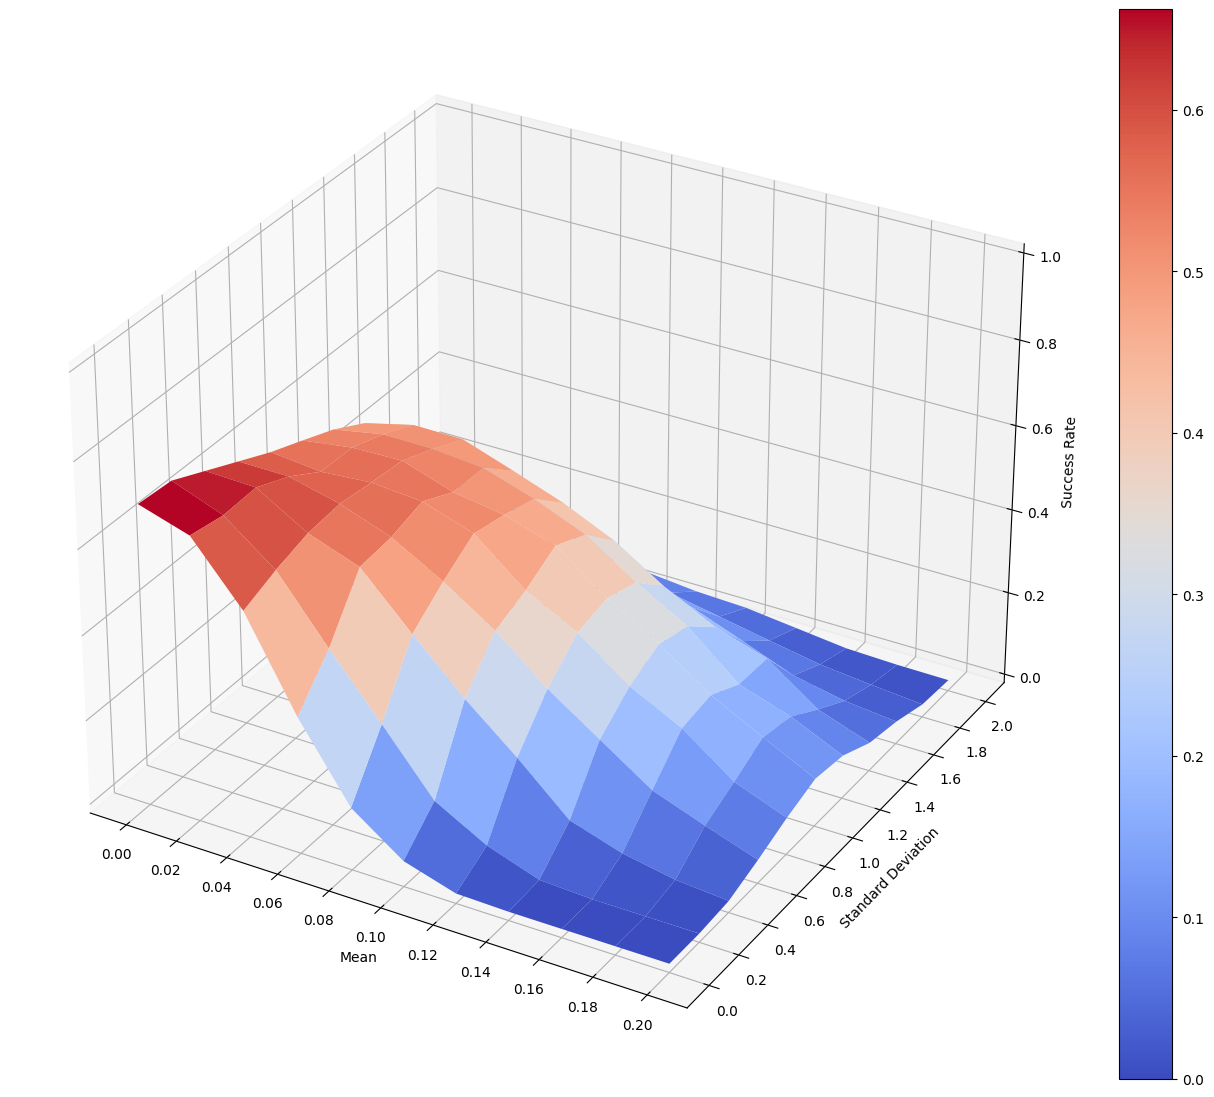

In [7]:
plt.figure(figsize=(15, 15))
plt.gcf().tight_layout()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
ax.set_xlabel("Mean")
ax.set_xticks(mus)
ax.set_ylabel("Standard Deviation")
ax.set_yticks(sigmas)
ax.set_zlabel("Success Rate")

ax.set_zlim(0, 1)

plt.gcf().colorbar(surf, fraction=0.046, pad=0.04)
plt.savefig("successRate.png")
plt.show()